## Approaches to Sentiment Analysis

1. The rule-based design (popular example is the VADER)
2. A machine learning model trained on data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Twitter Sentiment Analysis

[Errno 2] No such file or directory: '/content/drive/MyDrive/Twitter Sentiment Analysis'
/content


In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
import re
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

In [5]:
! pip install twython

In [6]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [7]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer

In [8]:
!pip install polyglot

     |████████████████████████████████| 126 kB 5.2 MB/s 
  Created wheel for polyglot: filename=polyglot-16.7.4-py2.py3-none-any.whl size=52577 sha256=d017a3cd8ea1ee0c5b3e71bf52cab6bdab6ebb4c40ef74ceb3ff79212e625bcc
  Stored in directory: /root/.cache/pip/wheels/09/bc/67/75c9de8e9726460bc0b101ad225ad025cb8ce9e0759beb9d52
Successfully built polyglot


In [9]:
!pip install PyICU

     |████████████████████████████████| 305 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for PyICU: filename=PyICU-2.9-cp37-cp37m-linux_x86_64.whl size=1375761 sha256=cc1ffe5f948d7ac6a16582218a5b8fb13b6cf2be26a89efea7d9166eca5cd1a8
  Stored in directory: /root/.cache/pip/wheels/28/88/93/6c1b06361e4cbd4e7f793fb456729f69798f9aa3fc2a791cd7
Successfully built PyICU


In [10]:
!pip install pycld2

     |████████████████████████████████| 41.4 MB 1.3 MB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9834326 sha256=345fc77cbeee9566fa5da76cd7b58050ff157dc27f63c521ed10826746aa40b4
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614
Successfully built pycld2


In [11]:
!pip install morfessor

In [12]:
!pip install vader-multi

     |████████████████████████████████| 126 kB 4.9 MB/s 


In [13]:
import polyglot
from polyglot.text import Text, Word

In [14]:
df1 = pd.read_csv('/content/drive/MyDrive/sentiment analysis/uniquedata1.csv', low_memory=False)
df2 = pd.read_csv('/content/drive/MyDrive/sentiment analysis/uniquedata2.csv', low_memory=False)
df3 = pd.read_csv('/content/drive/MyDrive/sentiment analysis/unique3.csv', lineterminator='\n', low_memory=False)

In [15]:
df = pd.concat([df1, df2, df3], ignore_index=True)

In [16]:
df1.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [17]:
### How to select 40k english tweets

#english = df[df.language == 'en']
#english = english.samplemple(n = 40000, random_state = 0)

In [18]:
df.hashtags

0         ['russianukrainianwar', 'rusiaucraniaguerra', ...
1         ['russianukrainianwar', 'rusiaucraniaguerra', ...
2         ['chernobyl', 'ukrainerussiawar', 'russianukra...
3         ['ukrainerussiawar', 'standwithukraine️', 'rus...
4         ['sanctionabramovych', 'standwithukraine', 'ru...
                                ...                        
725253                                                   []
725254                                                   []
725255    ['війна', 'марш', 'наживо', 'новини', 'останні...
725256                                                   []
725257                                                   []
Name: hashtags, Length: 725258, dtype: object

In [19]:
## put hashtag in front of the hashtags

df.hashtags = df.hashtags.map(lambda x: eval(x))\
.map(lambda x: ['#' + tag for tag in x])

In [20]:
english = df[df.language == 'en'].sample(n = 22907, random_state=52) #22907
russian = df[df.language == 'ru'].sample(n = 22907, random_state=52)
ukrain = df[df.language == 'uk']

In [21]:
tweets_eng = english[['tweet', 'hashtags']].reset_index(drop = True)
tweets_ru = russian[['tweet', 'hashtags']].reset_index(drop = True)
tweets_uk = ukrain[['tweet', 'hashtags']].reset_index(drop = True)

In [22]:
tweets_uk.head()

,tweet,hashtags
0,"Коротко по Украине. 10.03.2022. #Донбасс, #вой...","[#донбасс, #войнанадонбассе, #днр, #лнр, #укра..."
1,"Всі, хто кликав росію і путіна, ви чому сидите...",[#russianukrainianwar]
2,⚡️Месники: українська версія🇺🇦 #StandWithUkra...,"[#standwithukraine, #ukrainerussiawar, #russia..."
3,Після війни я обов‘язково… 💛💙 Обов‘язково пове...,[#russianukrainianwar]
4,Захід повинен закрити небо над Україною💛💙🙏 #Pe...,"[#petroporoshenko, #closetheskyukraine, #russi..."


In [23]:
before_cleaning = tweets_eng.copy()

## Data Cleaning

In [24]:
tweets_ru.tweet[0]

'да ето так.'

In [25]:
## English Tweets

tweets_eng.tweet = tweets_eng.tweet.map(lambda x: re.sub(r"http\S+", '', x))\
.map(lambda x: re.sub(r"@\S+", '', x))\
.map(lambda x: x.lower())

tweets_eng['tweet'] = tweets_eng.apply(lambda x: [word for word in x['tweet'].split() if word not in x['hashtags']], axis =1)\
.map(lambda x: ' '.join(x))

tweets_eng = tweets_eng.drop(columns = ['hashtags'])


## Russian Tweets

tweets_ru.tweet = tweets_ru.tweet.map(lambda x: re.sub(r"http\S+", '', x))\
.map(lambda x: re.sub(r"@\S+", '', x))

tweets_ru['tweet'] = tweets_ru.apply(lambda x: [word for word in x['tweet'].split() if word not in x['hashtags']], axis =1)\
.map(lambda x: ' '.join(x))

tweets_ru = tweets_ru.drop(columns = ['hashtags'])

## Ukrainian Tweets

tweets_uk.tweet = tweets_uk.tweet.map(lambda x: re.sub(r"http\S+", '', x))\
.map(lambda x: re.sub(r"@\S+", '', x))

tweets_uk['tweet'] = tweets_uk.apply(lambda x: [word for word in x['tweet'].split() if word not in x['hashtags']], axis =1)\
.map(lambda x: ' '.join(x))

tweets_uk = tweets_uk.drop(columns = ['hashtags'])

In [26]:
## English

print('Before cleaning:')
print('=============')

print(before_cleaning['tweet'][1])
print(before_cleaning['tweet'][10])
print(before_cleaning['tweet'][200])
print(before_cleaning['tweet'][58])
print(before_cleaning['tweet'][96])

Before cleaning:
@antiputler_news you know why extremists in Hungary supported Putin when taking Crimea? becuase they wanted to do the same with the south Slovak land... Hungary should be definetly kicked from EU and NATO till those extremists are in their government..
@ZelenskyyUa @OlafScholz USA stands with Ukraine. Stay strong.
Now let's jump in and PUMMEL Putin! 😡
@McFaul @ZelenskyyUa Putin wants a warm water port and wants to landlock Ukraine.
Afghan uncle becomes expert on Ukraine overnight, scientists baffled  https://t.co/WDgG2jyGOc via @thekachaloo   #Afghanistan #Ukraine #Russia #RussianUkrainianWar  #RussiaInvadedUkraine


In [27]:
## English

print('After cleaning:')
print('=============')

print(tweets_eng['tweet'][1])
print(tweets_eng['tweet'][10])
print(tweets_eng['tweet'][200])
print(tweets_eng['tweet'][58])
print(tweets_eng['tweet'][96])

After cleaning:
you know why extremists in hungary supported putin when taking crimea? becuase they wanted to do the same with the south slovak land... hungary should be definetly kicked from eu and nato till those extremists are in their government..
usa stands with ukraine. stay strong.
now let's jump in and pummel putin! 😡
putin wants a warm water port and wants to landlock ukraine.
afghan uncle becomes expert on ukraine overnight, scientists baffled via


## Write Sentiment Functions Using Ployglot

In [28]:
!polyglot download sentiment2.ru

[polyglot_data] Downloading package sentiment2.ru to
[polyglot_data]     /root/polyglot_data...


In [29]:
!polyglot download sentiment2.en

[polyglot_data] Downloading package sentiment2.en to
[polyglot_data]     /root/polyglot_data...


In [30]:
!polyglot download sentiment2.uk

[polyglot_data] Downloading package sentiment2.uk to
[polyglot_data]     /root/polyglot_data...


In [31]:
def PolarityUkr(tweet):

  language_detect = Text(tweet).language.name

  if language_detect == 'Ukrainian':
    try:
      polarity = Text(tweet).polarity
    except:
      polarity = 0
    return polarity

In [32]:
tweets_uk.loc[:, 'polarityPolyg'] = tweets_uk['tweet'].apply(PolarityUkr)

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

In [33]:
tweets_uk.head()

,tweet,polarityPolyg
0,"Коротко по Украине. 10.03.2022. #Донбасс, #вой...",NaN
1,"Всі, хто кликав росію і путіна, ви чому сидите...",0.0
2,⚡️Месники: українська версія🇺🇦 #StandWithUkrai...,0.0
3,Після війни я обов‘язково… 💛💙 Обов‘язково пове...,0.0
4,Захід повинен закрити небо над Україною💛💙🙏 #Pe...,1.0


In [34]:
tweets_uk.isnull().sum()

tweet               0
polarityPolyg    1339
dtype: int64

In [35]:
#Check all available languages in the ukrainain and russian tweets

In [36]:
def PolarityRus(tweet):

  language_detect = Text(tweet).language.name

  if language_detect == 'Russian':
    try:
      polarity = Text(tweet).polarity
    except:
      polarity = 0
    return polarity

In [37]:
tweets_ru.loc[:, 'polarityPolyg'] = tweets_ru['tweet'].apply(PolarityRus)

Streaming output truncated to the last 5000 lines.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect 

In [38]:
tweets_ru.head()

,tweet,polarityPolyg
0,да ето так.,NaN
1,Спасибо 🤍 Если бы ещё и все подписчики этих ад...,0.0
2,"Когда Путин рухнет, и расклад сил в Восточной ...",-1.0
3,"Бога ради, хотите жить в говне – живите. А НАТ...",1.0
4,"Что делает великим лидером г-на Путина?? тот, ...",NaN


In [39]:
tweets_ru.isnull().sum()

tweet               0
polarityPolyg    3415
dtype: int64

In [40]:
def PolarityEng(tweet):

  language_detect = Text(tweet).language.name

  if language_detect == 'English':
    try:
      polarity = Text(tweet).polarity
    except:
      polarity = 0
    return polarity

In [41]:
tweets_eng.loc[:, 'polarityPolyg'] = tweets_eng['tweet'].apply(PolarityEng)

Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
Detector is not able to dete

In [42]:
tweets_eng.head()

,tweet,polarityPolyg
0,ukrainians have expended a tremendous effort t...,1.000000
1,you know why extremists in hungary supported p...,-0.333333
2,"hey everybody, let's donate all our personal p...",0.000000
3,opinion: zelensky's ukraine is real. putin's d...,0.000000
4,"ha ha, get fucked, putin. canceled like you ca...",0.000000


In [43]:
tweets_eng.isnull().sum()

tweet              0
polarityPolyg    148
dtype: int64

In [44]:
## drop missing observation (the tweets that were not identified as the language in question)

tweets_ru = tweets_ru.dropna()
tweets_uk = tweets_uk.dropna()
tweets_eng = tweets_eng.dropna()

In [45]:
tweets_uk['classification'] = np.zeros(tweets_uk.shape[0])
tweets_uk['classification'] = np.where(tweets_uk['polarityPolyg'] >=0.05, 'positive', tweets_uk['classification'])
tweets_uk['classification'] = np.where(tweets_uk['polarityPolyg'] <=-0.05, 'negative', tweets_uk['classification'])
tweets_uk['classification'] = np.where((tweets_uk['polarityPolyg'] < 0.05) & (tweets_uk['polarityPolyg'] > -0.05), 'neutral', tweets_uk['classification'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [46]:
tweets_ru['classification'] = np.zeros(tweets_ru.shape[0])
tweets_ru['classification'] = np.where(tweets_ru['polarityPolyg'] >=0.05, 'positive', tweets_ru['classification'])
tweets_ru['classification'] = np.where(tweets_ru['polarityPolyg'] <=-0.05, 'negative', tweets_ru['classification'])
tweets_ru['classification'] = np.where((tweets_ru['polarityPolyg'] < 0.05) & (tweets_ru['polarityPolyg'] > -0.05), 'neutral', tweets_ru['classification'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
tweets_eng['classification'] = np.zeros(tweets_eng.shape[0])
tweets_eng['classification'] = np.where(tweets_eng['polarityPolyg'] >=0.05, 'positive', tweets_eng['classification'])
tweets_eng['classification'] = np.where(tweets_eng['polarityPolyg'] <=-0.05, 'negative', tweets_eng['classification'])
tweets_eng['classification'] = np.where((tweets_eng['polarityPolyg'] < 0.05) & (tweets_eng['polarityPolyg'] > -0.05), 'neutral', tweets_eng['classification'])

In [48]:
tweets_eng.classification.value_counts()

neutral     8796
negative    8271
positive    5692
Name: classification, dtype: int64

In [49]:
tweets_uk.classification.value_counts()

neutral     12394
positive     4881
negative     4293
Name: classification, dtype: int64

In [50]:
tweets_ru.classification.value_counts()

neutral     9842
positive    5529
negative    4121
Name: classification, dtype: int64

In [51]:
tweets_ru.loc[:, 'country'] = ['Russian']*tweets_ru.shape[0]
tweets_uk.loc[:, 'country'] = ['Ukrainian']*tweets_uk.shape[0]
tweets_eng.loc[:, 'country'] = ['English']*tweets_eng.shape[0]

In [52]:
newdf = pd.concat([
           tweets_ru.loc[:, ('classification', 'country')],
           tweets_uk.loc[:, ('classification', 'country')],
           tweets_eng.loc[:, ('classification', 'country')]
])

newdf.head()

,classification,country
1,neutral,Russian
2,negative,Russian
3,positive,Russian
5,negative,Russian
6,negative,Russian


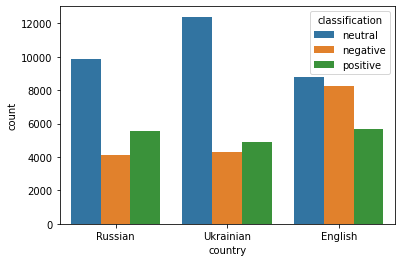

In [53]:
sns.countplot(x = 'country', data = newdf, hue ='classification')
plt.show()

**English** count vectorizer

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

In [55]:
cv = CountVectorizer(stop_words='english')
vec = cv.fit_transform(tweets_eng.tweet)

In [56]:
vecT = vec.toarray()
vecdf = pd.DataFrame(vecT, columns = cv.get_feature_names_out())

In [57]:
pd.DataFrame(vecdf.sum(axis = 0))

,0
00,12
000,229
0000000000000,1
000ft,1
000s,1
...,...
𝗢𝘀𝘁𝗮𝗽,1
𝗥𝗧𝗘,1
𝗦𝗹𝘆𝘃𝘆𝗻𝘀𝗸𝘆,1
𝗨𝗞,1


In [58]:
df3 = pd.DataFrame(vecdf.sum(axis = 0)).sort_values(by = [0], ascending = False)
df3.head()

,0
putin,12544
ukraine,6618
war,4367
russia,4058
zelensky,2886


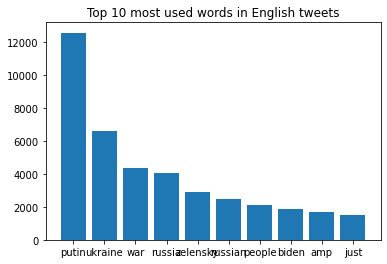

In [59]:
plt.bar(df3.index[:10],df3[0][:10])
plt.title('Top 10 most used words in English tweets')
plt.show()

**UKRAIN** count vectorizer helps count the frequency of the most popular words

In [60]:
cvuk = CountVectorizer(min_df= 15)
vecuk = cv.fit_transform(tweets_uk.tweet)

In [61]:
dataCV=cvuk.fit_transform(tweets_uk.tweet)

In [62]:
dataCV_df=pd.DataFrame(dataCV.toarray(), columns=cvuk.get_feature_names())
dataCV_df


,00,000,02,03,10,100,1000,11,12,13,...,їсти,їх,їхати,їхня,їхнє,їхні,їхній,їхніх,її,ґвалтують
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21563,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21564,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21566,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
pd.DataFrame(dataCV_df.sum(axis = 0))

,0
00,78
000,36
02,76
03,70
10,122
...,...
їхні,57
їхній,29
їхніх,27
її,402


In [64]:
df4 = pd.DataFrame(dataCV_df.sum(axis = 0)).sort_values(by = [0], ascending = False)
df4.head()

,0
не,10261
путін,7212
що,6921
зеленський,6918
на,5740


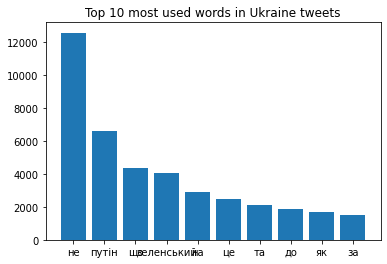

In [65]:
plt.bar(df4.index[:10],df3[0][:10])
plt.title('Top 10 most used words in Ukraine tweets')
plt.show()

**Russian** count vectorizer

In [66]:
cvru = CountVectorizer(min_df= 15)
vecuk = cv.fit_transform(tweets_ru.tweet)

In [67]:
dataCV=cvru.fit_transform(tweets_ru.tweet)

In [68]:
dataCV_df=pd.DataFrame(dataCV.toarray(), columns=cvru.get_feature_names())
dataCV_df

,00,000,02,03,10,100,11,12,13,14,...,язык,языка,языке,языку,яйца,якобы,яо,японии,ясно,яхты
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19489,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
pd.DataFrame(dataCV_df.sum(axis = 0))

,0
00,54
000,44
02,34
03,131
10,141
...,...
якобы,46
яо,29
японии,19
ясно,61


In [70]:
df5 = pd.DataFrame(dataCV_df.sum(axis = 0)).sort_values(by = [0], ascending = False)
df5.head()

,0
путин,12696
не,9813
что,7459
на,5483
это,4245


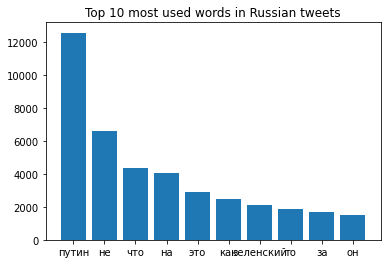

In [71]:
plt.bar(df5.index[:10],df3[0][:10])
plt.title('Top 10 most used words in Russian tweets')
plt.show()

In [72]:
## This code crashes the runtime session
#vecTuk = vecuk.toarray()
#vecdfuk = pd.DataFrame(vecTuk, columns = cv.get_feature_names_out())

In [73]:
#df3 = pd.DataFrame(vecdfuk.sum(axis = 0)).sort_values(by = [0], ascending = False)
#df3.head()

In [74]:
#plt.bar(df3.index[:7],df3[0][:7])
#plt.title('Top 7 most used words in Ukrain tweets')
#plt.show()

In [75]:
cv=CountVectorizer(stop_words=stop_words,min_df=10)
dataCV=cv.fit_transform(tweets_eng.tweet)
dataCV_df=pd.DataFrame(dataCV.toarray(), columns=cv.get_feature_names())

NameError: ignored